# Compute ADU counts over time

## 0. Set up

In [2]:
import json
import geopandas as gpd
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
import rasterio
import rasterio.features
import rasterio.plot
import shapely
from shapely.geometry import box, Polygon
from tqdm import tqdm

tqdm.pandas()

In [3]:
def visualize_tile_full_year(fn, year):
    tile_bounds = get_bounds(tile_bounds_dict_all[year], fn)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    infer_tile = gpd.clip(building_footprints_infer[year], tile_bounds)
    zone_tile = gpd.clip(zoning, tile_bounds)

    raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(fn)))

    plt.clf()
    fig, ax = plt.subplots(figsize=(4, 4))
    rasterio.plot.show(raster, ax=ax,)
    zone_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='black', alpha=0.5)
    osm_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue')
    infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.5)
    plt.show()
    
def get_bounds(tile_bounds_dict, file_name):
    bounds = tile_bounds_dict[file_name]
    
    # Build polygon
    tile_poly = box(bounds[0][0], bounds[0][1], bounds[2][0], bounds[2][1])
    return tile_poly

def load_data(shapefile_fp, oak_fp):
    # CBG shapefiles
    cbg = gpd.read_file(os.path.join(shapefile_fp, 'tl_2021_06_bg'))
    cbg_scc = cbg.loc[cbg['COUNTYFP'] == '085']
    
    # Get San Jose city SHP
    scc_cities = gpd.read_file(os.path.join(shapefile_fp, 'City_Limits'))
    sj_city = scc_cities.loc[scc_cities['NAME'] == 'SAN JOSE']
    
    # Get CBGs in SJ city
    cbg_scc = cbg_scc.to_crs(sj_city.crs)
    cbg_sj = gpd.clip(cbg_scc, sj_city)
    
    # Zoning data
    zoning = gpd.read_file(os.path.join(oak_fp, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson'))
    zoning = zoning[(zoning['ZONINGABBREV'].str.contains('R-')) | \
                ((zoning['ZONINGABBREV'] == 'A(PD)') & (zoning['PDUSE'] == 'Res'))]
    zoning = zoning.to_crs(cbg_sj.crs)
    
    return cbg_sj, zoning

## 1. Load data / Paths

In [4]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
TIF_FP = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/raw_tif', 
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/raw_tif',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
}

INFERENCES_DIR = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/infer',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/infer',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
}
YEARS = ['2016', '2018', '2020']

In [5]:
# Load tile dict for each year
tile_bounds_dict_all = {}
for year in ['2016', '2018']:
    OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}'.format(year))
    with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
        tile_bounds_dict = json.load(f)
        tile_bounds_dict_all[year] = tile_bounds_dict
        
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference')
with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
    tile_bounds_dict = json.load(f)
    tile_bounds_dict_all['2020'] = tile_bounds_dict

In [6]:
# Load inference files for 2016, 2018, 2020
building_footprints_infer = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference/inference_building_processed')
building_footprints_infer16 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2016/inference_building_processed')
building_footprints_infer18 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2018/inference_building_processed')

# Load SJ shapefiles, zoning data and OSM data
cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
building_footprints_osm = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference/osm_building_processed')

In [9]:
# Consolidate inferred buildings for all years and limit to small buildings
building_footprints_infer = {
    '2016': building_footprints_infer16,
    '2018': building_footprints_infer18,
    '2020': building_footprints_infer
}

small_bfi = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer.items():
    gdf['year'] = year
    small_bfi = pd.concat([small_bfi, gdf])
small_bfi = small_bfi.loc[small_bfi['small'] == 1]

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [10]:
# Get tiles for all years
tiles_gdf = {}
for year in YEARS:
    tiles = glob.glob(os.path.join(INFERENCES_DIR[year], '*.npy'))
    tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]
    tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

    tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
        lambda name: get_bounds(tile_bounds_dict_all[year], name) if name in list(tile_bounds_dict_all[year].keys()) else None
    )
    tiles_gdf[year] = gpd.GeoDataFrame(tile_metrics_pd.copy())

100%|██████████| 3074/3074 [00:00<00:00, 19103.55it/s]


In [ ]:
tiles_gdf['2016'].head()

In [ ]:
tile_intersection = tiles_gdf['2016'].geometry.unary_union

<Figure size 640x480 with 0 Axes>

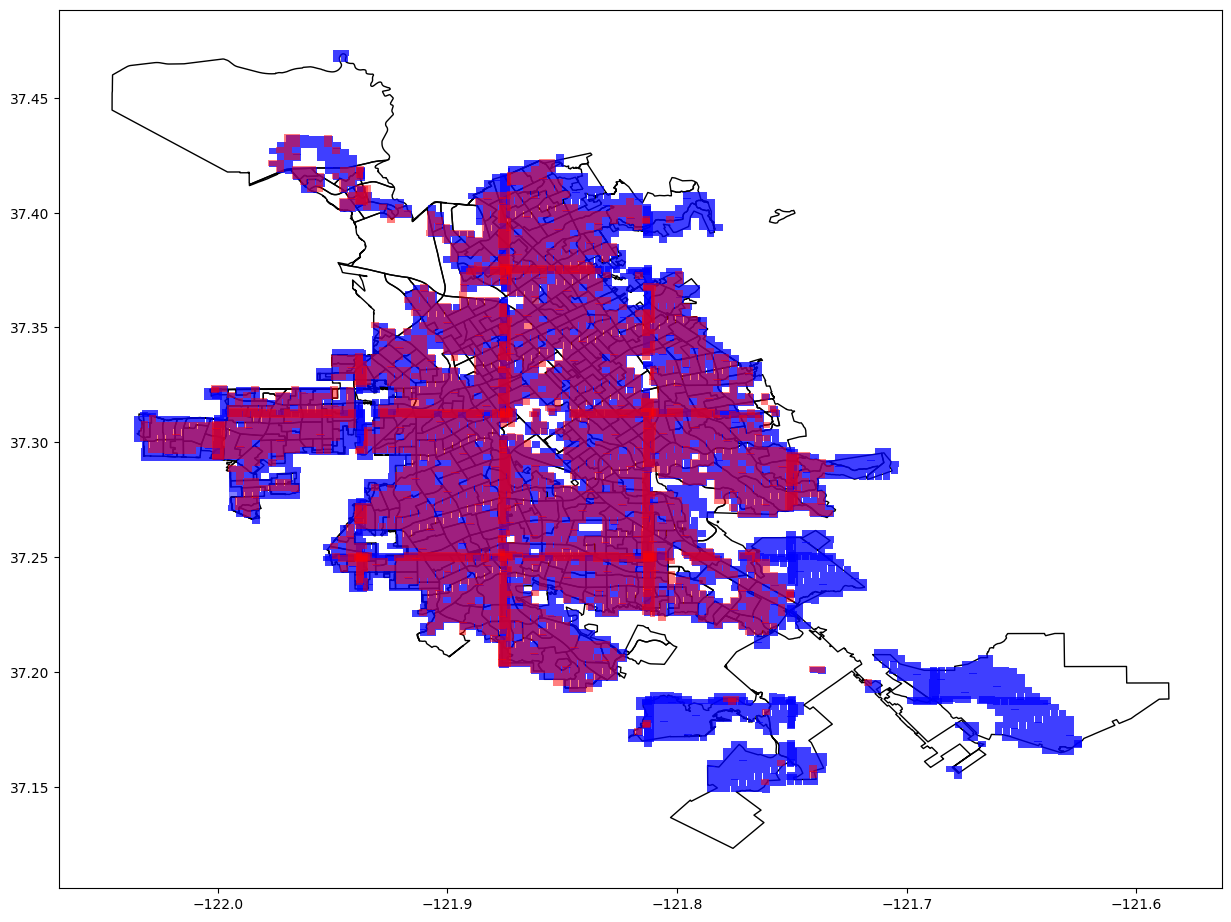

In [16]:
colors = {'2016': 'blue', '2018': 'blue', '2020': 'red'}


plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
for year in ['2016', '2018', '2020']:
    tiles_gdf[year].plot(ax=ax, facecolor=colors[year], alpha=0.5)
plt.show()



## 2. Raw inferences

In [47]:
# Number of tiles for each year
for year in [YEARS]:
    print('Year: {}; Num tiles: {}'.format(year, len(list(tile_bounds_dict_all[year].keys()))))

Year: 2016; Num tiles: 4648
Year: 2018; Num tiles: 4648
Year: 2020; Num tiles: 3074


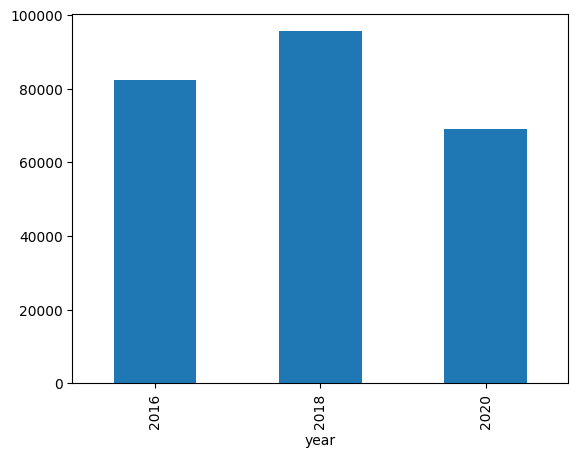

In [15]:
# Trends in raw small building counts
n_small_ts = small_bfi.groupby('year')['GEOID'].count()
n_small_ts.plot.bar()
plt.show()

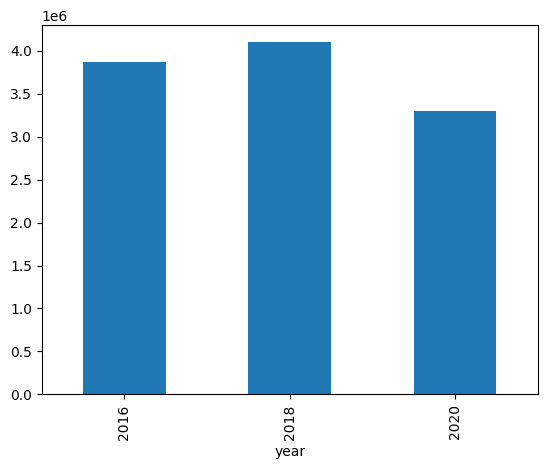

In [16]:
# Trends in raw small building area
a_small_ts = small_bfi.groupby('year')['area'].sum()
a_small_ts.plot.bar()
plt.show()

In [51]:
# Visualize tiles
#visualize_tile_full_year('m_3712149_ne_10_060_20200525_358', '2020')

In [52]:
#visualize_tile_full_year('m_3712149_ne_10_h_20160529_216', '2016')

In [50]:
# Limit inferences to areas with tile overlap across all years